# Imports

In [1]:
#!pip install -q segmentation_models_pytorch

In [2]:
import sys
sys.path.append("../input/pretrained-models-pytorch")
sys.path.append("../input/efficientnet-pytorch")
sys.path.append("/kaggle/input/timm-pretrained-resnest/resnest/")
sys.path.append("/kaggle/input/smp-github/segmentation_models.pytorch-master")

In [3]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/timm-pretrained-resnest/resnest/gluon_resnest26-50eb607c.pth /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import yaml
import torchvision.models as models
import segmentation_models_pytorch as smp
import gc
from matplotlib import animation
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/kaggle/working/../input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/kaggle/working/../input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/kaggle/working/../input/pretrained-models-pytorch/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


# Config

In [5]:
with open("/kaggle/input/contrailmodels/3c512px/3c512px/config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Utilites

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
def get_band_images(idx: str, parrent_folder: str, band: str) -> np.array:
    return np.load(os.path.join(config['data_dir'], parrent_folder, idx, f'band_{band}.npy'))

In [8]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])


def get_ash_color_images(idx: str, parrent_folder: str, get_mask_frame_only=False, frame_num=4) -> np.array:
    band11 = get_band_images(idx, parrent_folder, '11')
    band14 = get_band_images(idx, parrent_folder, '14')
    band15 = get_band_images(idx, parrent_folder, '15')
    
    if get_mask_frame_only or config['model']['in_channels'] == 3:
        band11 = band11[:,:,frame_num]
        band14 = band14[:,:,frame_num]
        band15 = band15[:,:,frame_num]

    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    return false_color

In [9]:
def get_mask_image(idx: str, parrent_folder: str) -> np.array:
    return np.load(os.path.join(config['data_dir'], parrent_folder, idx, 'human_pixel_masks.npy')) 

# Dataset

In [10]:
#Create a train dataframe
df_train_main = pd.DataFrame({'idx': os.listdir(f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'), 'data_set': 'train'})
df_validation_main = pd.DataFrame({'idx': os.listdir(f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation'), 'data_set': 'validation'})
df_test_main = pd.DataFrame({'idx': os.listdir(f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/test'), 'data_set': 'test'})
if config['mix_train_v_validation']:
    df_train_main = pd.concat([df_train_main, df_validation_main], ignore_index=True)

In [11]:
def get_fold_dataframes(df_main: pd.DataFrame, fold: int, use_val_when_not_mix_train: bool = True) -> tuple[pd.DataFrame, pd.DataFrame]:
    kf = KFold(n_splits=config['n_splits'], random_state=config['seed'], shuffle=True)
    for i, (train_index, test_index) in enumerate(kf.split(df_main)):
        if i == fold:
            _df_train = df_train_main.iloc[train_index]
            _df_test = df_train_main.iloc[test_index]
            if use_val_when_not_mix_train and not config['mix_train_v_validation']:
                _df_test = pd.concat([_df_test, df_validation_main], ignore_index=True)
            return _df_train, _df_test
    raise ValueError(f"Invalid fold was given! Given fold:{fold}, has to be less than {config['n_splits']}! Check config!")        

In [12]:
class ContrailsAshDatasetVal(torch.utils.data.Dataset):
    def __init__(self, df_img_idxs: pd.DataFrame):
        self.df_idx: pd.DataFrame = df_img_idxs
            
    def __len__(self):
        return len(self.df_idx)
    
    def __getitem__(self, idx):
        image_id: str = str(self.df_idx.iloc[idx]['idx'])
        image_parrent_folder = str(self.df_idx.iloc[idx]['data_set'])
        images = torch.tensor(np.reshape(get_ash_color_images(image_id, image_parrent_folder, get_mask_frame_only=False), (256, 256, config['model']['in_channels']))).to(torch.float32).permute(2, 0, 1)
        mask = torch.tensor(get_mask_image(image_id, image_parrent_folder)).to(torch.float32).permute(2, 0, 1)
        return image_id, images, mask

In [13]:
class ContrailsAshDatasetTest(torch.utils.data.Dataset):
    def __init__(self, df_img_idxs: pd.DataFrame):
        self.df_idx: pd.DataFrame = df_img_idxs
            
    def __len__(self):
        return len(self.df_idx)
    
    def __getitem__(self, idx):
        image_id: str = str(self.df_idx.iloc[idx]['idx'])
        image_parrent_folder = str(self.df_idx.iloc[idx]['data_set'])
        images = torch.tensor(np.reshape(get_ash_color_images(image_id, image_parrent_folder, get_mask_frame_only=False), (256, 256, config['model']['in_channels']))).to(torch.float32).permute(2, 0, 1)
        return image_id, images

# Model

In [14]:
class Upsampled(nn.Module):
    """
    Simple wrapper to upscale input at runtime, and automatically downscaled it
    """
    def __init__(self, back_bone: nn.Module):
        super(Upsampled, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.back_bone = back_bone
        self.down = nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False)

    def forward(self, x):
        # Forward pass through the layers
        x = self.up(x)
        x = self.back_bone(x)
        x = self.down(x)
        return x
    
    def forward_no_downsample_back(self, x):
        # Forward pass through the layers
        x = self.up(x)
        x = self.back_bone(x)
        return x 

In [15]:
def get_model():
    core = smp.Unet(
        encoder_name=config['model']['encoder_name'],
        encoder_weights=config['model']['encoder_weights'],
        in_channels=config['model']['in_channels'],   
        classes=config['model']['classes'],
        activation= None if config['model']['activation'] == 'None' else config['model']['activation']
    )
    if config['upsamled']:
        model = Upsampled(core)
    else:
        model = core
    model.to(device)
    return model

# Assembly

In [16]:
from scipy.special import expit

def sigmoid(x):
    # use scipy implmention of sigmoid to avoid overflow
    return expit(x) # return 1 / (1 + np.exp(-x))

In [18]:
df_models = pd.DataFrame({'model': ['4.pt', '5.pt', '6.pt'],
                          'set': ['3c512pxV3/3c512pxV3', '3c512pxV3/3c512pxV3', '3c512pxV3/3c512pxV3']})
model_base = '/kaggle/input/contrailmodels'

# Eval

## Find Optimal Threshold

In [20]:
find_optimal_threshold = True

In [21]:
if find_optimal_threshold:
    df_validation = df_validation_main#[:256]

    dataset_val = ContrailsAshDatasetVal(df_validation)
    data_loader_val = DataLoader(dataset_val, batch_size=config['batch_size'], shuffle=False, num_workers=2, drop_last=False)

    # created a map to store and accumulate model predictions
    proba_preds = {}
    # Initilise the map
    for idx in df_validation['idx']:
        proba_preds[idx] = np.zeros((256, 256), dtype=np.float16)

    for i in df_models.index:
        print(f"{df_models.iloc[i]['set']} - {df_models.iloc[i]['model']}")
        # Load config for thsi model
        with open(f"{model_base}/{df_models.iloc[i]['set']}/config.yaml", "r") as file:
            config = yaml.safe_load(file)

        # Load the model
        model = get_model()
        model_path = f"{model_base}/{df_models.iloc[i]['set']}/{df_models.iloc[i]['model']}"
        if torch.cuda.is_available():
            model.load_state_dict(torch.load(model_path))
        else:
            model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()
        model.to(device)

        #Make predictions
        with torch.no_grad():
            for i, data in enumerate(data_loader_val):
                image_ids, inputs, target = data
                inputs = inputs.to(device)#.float()
                target = target.to(device)#.float()
                pred = model.forward(inputs)

                pred = pred.cpu().detach().numpy()
                pred = sigmoid(pred)
                for j in range(len(image_ids)):
                    proba_preds[image_ids[j]] += pred[j, 0, :, :]


        # Clenup
        torch.cuda.empty_cache()        
        gc.collect()

    # Devide by the number of models to return prediction back to 0..1 range
    for idx in df_validation['idx']:
        proba_preds[idx] = proba_preds[idx] / float(len(df_models))

3c512pxV3/3c512pxV3 - 4.pt
3c512pxV3/3c512pxV3 - 5.pt
3c512pxV3/3c512pxV3 - 6.pt


In [22]:
class DiceThresholdDataSet(torch.utils.data.Dataset):
    def __init__(self, df_img_idxs: pd.DataFrame):
        self.df_idx: pd.DataFrame = df_img_idxs
            
    def __len__(self):
        return len(self.df_idx)
    
    def __getitem__(self, idx):
        image_id: str = str(self.df_idx.iloc[idx]['idx'])
        pred = proba_preds[image_id]
        proba_preds[image_id] = None # very importante, after reading the assembly prediction we need to release the memory, otherwise we would not gave enought to calculcate the global dice
        mask = torch.tensor(get_mask_image(image_id, 'validation')).to(torch.float32).permute(2, 0, 1).squeeze()
        return pred, mask

In [23]:
class Dice(nn.Module):
    def __init__(self, use_sigmoid=True):
        super(Dice, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.use_sigmoid = use_sigmoid

    def forward(self, inputs, targets, smooth=1):
        if self.use_sigmoid:
            inputs = self.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2.0 *intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice

In [24]:
class DiceThresholdTester:
    
    def __init__(self, data_loader: torch.utils.data.DataLoader):
        self.model = model
        self.data_loader = data_loader
        self.cumulative_mask_pred = []
        self.cumulative_mask_true = []
        
    def precalculate_prediction(self) -> None:
        with torch.no_grad():

            for pred, mask in self.data_loader:
                self.cumulative_mask_pred.append(pred)
                self.cumulative_mask_true.append(mask)

            self.cumulative_mask_pred = np.concatenate(self.cumulative_mask_pred, axis=0)
            self.cumulative_mask_true = np.concatenate(self.cumulative_mask_true, axis=0)

            self.cumulative_mask_pred = torch.flatten(torch.from_numpy(self.cumulative_mask_pred))
            self.cumulative_mask_true = torch.flatten(torch.from_numpy(self.cumulative_mask_true))
            
        torch.cuda.empty_cache()        
        gc.collect()
    
    def test_threshold(self, threshold: float) -> float:
        _dice = Dice(use_sigmoid=False)
        after_threshold = np.zeros(self.cumulative_mask_pred.shape)
        after_threshold[self.cumulative_mask_pred[:] > threshold] = 1
        after_threshold[self.cumulative_mask_pred[:] < threshold] = 0
        after_threshold = torch.flatten(torch.from_numpy(after_threshold))
        return _dice(self.cumulative_mask_true, after_threshold).item()

In [25]:
optim_threshold = 0.25
optim_threshold_ass = 0.25

Best Threshold: 0.33 with dice: 0.6524522169846063


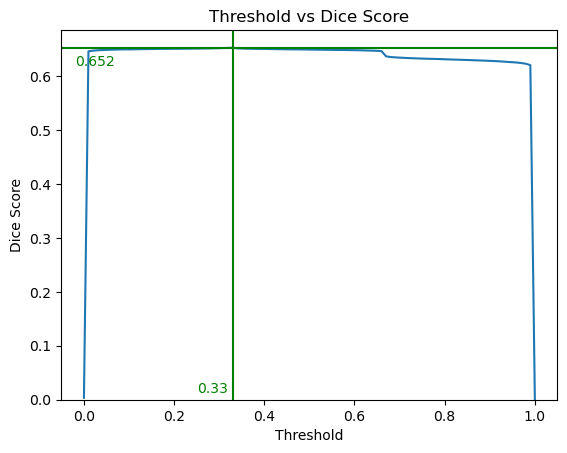

In [26]:
if find_optimal_threshold:
    dice_dataset = DiceThresholdDataSet(df_validation)
    dice_dataloader = DataLoader(dice_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2, drop_last=False)


    dice_threshold_tester = DiceThresholdTester(dice_dataloader)
    dice_threshold_tester.precalculate_prediction()
    
    thresholds_to_test = [round(x * 0.01, 2) for x in range(101)]

    optim_threshold = 0.05
    best_dice_score = -1

    thresholds = []
    dice_scores = []

    for t in thresholds_to_test:
        dice_score = dice_threshold_tester.test_threshold(t)
        if dice_score > best_dice_score:
            best_dice_score = dice_score
            optim_threshold = t

        thresholds.append(t)
        dice_scores.append(dice_score)

    print(f'Best Threshold: {optim_threshold} with dice: {best_dice_score}')
    df_threshold_data = pd.DataFrame({'Threshold': thresholds, 'Dice Score': dice_scores})
    
    sns.lineplot(data=df_threshold_data, x='Threshold', y='Dice Score')
    plt.axhline(y=best_dice_score, color='green')
    plt.axvline(x=optim_threshold, color='green')
    plt.text(-0.02, best_dice_score * 0.96, f'{best_dice_score:.3f}', va='center', ha='left', color='green')
    plt.text(optim_threshold - 0.01, 0.02, f'{optim_threshold}', va='center', ha='right', color='green')
    plt.ylim(bottom=0)
    plt.title('Threshold vs Dice Score')
    plt.show()

In [27]:
#optim_threshold_ass = optim_threshold

# Preview Predictions

In [28]:
preview = False

In [29]:
if preview:
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    batches_to_show = 4
    model.eval()

    for i, data in enumerate(data_loader_val):
        images, mask = data

        # Predict mask for this instance
        if torch.cuda.is_available():
            images = images.cuda()
        predicated_mask = sigmoid(model.forward(images[:, :, :, :]).cpu().detach().numpy())

        # Apply threshold
        predicated_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
        predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
        predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1

        images = images.cpu()

        for img_num in range(0, images.shape[0]):
            fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
            axes = axes.flatten()

            # Show groud trought 
            axes[0].imshow(mask[img_num, 0, :, :])
            axes[0].axis('off')
            axes[0].set_title('Ground Truth')

            # Show ash color scheme input image
            axes[1].imshow( np.concatenate(
                (
                np.expand_dims(images[img_num, 4, :, :], axis=2),
                np.expand_dims(images[img_num, 12, :, :], axis=2),
                np.expand_dims(images[img_num, 20, :, :], axis=2)
            ), axis=2))
            axes[1].axis('off')
            axes[1].set_title('Ash color scheeme input - Frame 4')

            # Show predicted mask
            axes[2].imshow(predicated_mask[img_num, 0, :, :], vmin=0, vmax=1)
            axes[2].axis('off')
            axes[2].set_title('Predicted probability mask')

            # Show predicted mask after threshold
            axes[3].imshow(predicated_mask_with_threshold[img_num, :, :])
            axes[3].axis('off')
            axes[3].set_title('Predicted mask with threshold')
            plt.show()

        if i + 1 >= batches_to_show:
            break
    torch.cuda.empty_cache()        
    gc.collect()

# Submit

In [30]:
#source https://www.kaggle.com/code/inversion/contrails-rle-submission?scriptVersionId=128527711&cellId=4

def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [31]:
dataset_test = ContrailsAshDatasetTest(df_test_main)
data_loader_test = DataLoader(dataset_test, batch_size=config['batch_size'], shuffle=False, num_workers=2, drop_last=False)

# created a map to store and accumulate model predictions
proba_preds = {}
# Initilise the map
for idx in df_test_main['idx']:
    proba_preds[idx] = np.zeros((256, 256), dtype=np.float16)

    
for i in df_models.index:
    print(f"{df_models.iloc[i]['set']} - {df_models.iloc[i]['model']}")
    # Load config for thsi model
    with open(f"{model_base}/{df_models.iloc[i]['set']}/config.yaml", "r") as file:
        config = yaml.safe_load(file)

    # Load the model
    model = get_model()
    model_path = f"{model_base}/{df_models.iloc[i]['set']}/{df_models.iloc[i]['model']}"
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    model.to(device)

    #Make predictions
    with torch.no_grad():
        for i, data in enumerate(data_loader_test):
            image_ids, inputs = data
            inputs = inputs.to(device)#.float()
            pred = model.forward(inputs)

            pred = pred.cpu().detach().numpy()
            pred = sigmoid(pred)
            for j in range(len(image_ids)):
                proba_preds[image_ids[j]] += pred[j, 0, :, :]


    # Clenup
    torch.cuda.empty_cache()        
    gc.collect()

for idx in df_test_main['idx']:
    # Devide by the number of models to return prediction back to 0..1 range
    proba_preds[idx] = proba_preds[idx] / float(len(df_models))
    
    # Apply threshold
    proba_preds[idx][proba_preds[idx] > optim_threshold_ass] = 1
    proba_preds[idx][proba_preds[idx] < optim_threshold_ass] = 0

3c512pxV3/3c512pxV3 - 4.pt
3c512pxV3/3c512pxV3 - 5.pt
3c512pxV3/3c512pxV3 - 6.pt


In [32]:
class SubmitDataSet(torch.utils.data.Dataset):
    def __init__(self, df_img_idxs: pd.DataFrame):
        self.df_idx: pd.DataFrame = df_img_idxs
            
    def __len__(self):
        return len(self.df_idx)
    
    def __getitem__(self, idx):
        image_id: str = str(self.df_idx.iloc[idx]['idx'])
        pred = proba_preds[image_id]
        proba_preds[image_id] = None # very importante, after reading the assembly prediction we need to release the memory
        return image_id, pred

In [33]:
submit_dataset = SubmitDataSet(df_test_main)
submit_dataloader = DataLoader(submit_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2, drop_last=False)

In [34]:
submission = pd.read_csv('/kaggle/input/google-research-identify-contrails-reduce-global-warming/sample_submission.csv', index_col='record_id')

In [35]:
for i, data in enumerate(submit_dataloader):
    idx, pred = data
    
    for img_num in range(0, pred.shape[0]):
        current_mask = pred[img_num, :, :]
        current_image_id = idx[img_num]
        
        submission.loc[int(current_image_id), 'encoded_pixels'] = list_to_string(rle_encode(current_mask))

In [36]:
submission

,encoded_pixels
record_id,
1000834164244036115,-
1002653297254493116,-


In [37]:
submission.to_csv('submission.csv')